# Deep learning with Entity Embedding

- Written by Yeon Soo Choi, Research Unit, World Customs Organization
- Updated on 2020. 6. 30.

## Summary

### Deep Learning (Neural Network model)

Now, we are moving from lego for 2-years old to lego for adult. Previously, we have deployed a kind of pre-built (ready-to-use) models such as XGBoost. While we can tune the models with hyperparameters (e.g. the number of trees, the maximum height (depth) of individual tree), the core algorithm of the model is unchangeable. In contrast, a neural network model (known as Deep Learning model) is more flexible, and could be more powerful upon our construction. We can design how data flows and how individual variables interact with others at different points during their journey to the final destination. I feel like constructing a water traffic network. No worries at all. Still, we have very good pre-built parts/components for contructing our own models.

### Entity Embedding

Embedding is another way of converting categorical variables to numeric variables.
In our data, we have 12708 unique importer-ids. If we one-hot-encode the importer-ids, we may generate additional 12708 (actually less than 12708) variables (columns); ie. [0,0,0,...] for importer A [1,0,0,...] for importer B, and [0,0,1,...] for importer C. This approach costs significantly high computational power of our machine and time. The solution is the entity embedding, from which we can add only 3 columns; ie. [0.1, 1.33, 0.7] for importer A, [0.99, 3.1, 3.3] for importer B and [0.11, 1.3, 0.65] for importer C. The values for each entity is determined during the training in a way to optimize the model's performance. An additional benefit of entity embedding is that we can recognize who importer C is similar to importer A as their embedding values are similar to each other.  

## Outline

[**1. Environmental setting and data loading**](#id1)  
[**2. Data preprocessing**](#id2)  
[**3. Construct the model**](#id3)  
[**4. Train the model**](#id4)  
[**5. Test the model (Predict frauds in test-data**](#id5)  
[**6. Evaluate the model performance**](#id6)

## 1. Environment setting and data loading <a id='id1'></a>

In [1]:
# Prepare environments
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import random
pd.set_option('display.max_columns', 500)

plt.style.use('fivethirtyeight')

In [2]:
# Load data
#df_raw = pd.read_csv('~/SyntheticDataGeneration_server/CTGAN/synthetic_data2.csv')
df_raw = pd.read_csv('../data/mgr3-1019.csv', low_memory=False)

# only imports
df_raw = df_raw[df_raw['destinacion_mercancia'] == 'IM']

In [3]:
# Check columns
df_raw.columns

Index(['identificador', 'anno', 'anno_mes_registro', 'aduana', 'numero_serial',
       'numero_registro', 'numero_declaracion', 'ingreso_salida',
       'destinacion_mercancia', 'patron_operacion', 'regimen',
       'agente_aduanas', 'digitador', 'agencia_carga', 'puerto_embarque',
       'pais_procedencia', 'contribuyente', 'almacen', 'deposito_fiscal',
       'tipo_transporte', 'tipo_pago', 'codigo_banco', 'version_declaracion',
       'oficial_aduanero', 'canal_selectividad', 'item', 'inciso_arancelario',
       'inciso_arancelario_old', 'pais_origen_destino',
       'pais_origen_destino_old', 'cuantia', 'unidad_medida',
       'preferencia_arancelaria', 'identificacion_carga', 'proveedor',
       'consolidadora', 'fecha_arribo', 'fecha_ingreso_almacen',
       'fecha_registro_dua', 'fecha_pago', 'fecha_recepcion_fisica',
       'fecha_asignacion_canal', 'fecha_autorizacion_salida', 'fecha_salida',
       'cif', 'fob', 'flete', 'seguro', 'otros_valores', 'peso_bruto',
       'peso_n

In [92]:
# Date cleaning (delete a column)
#del df['Unnamed: 0']
df = df_raw.copy()

In [93]:
# View/print 5 samples of df
df.sample(5)

,identificador,anno,anno_mes_registro,aduana,numero_serial,numero_registro,numero_declaracion,ingreso_salida,destinacion_mercancia,patron_operacion,regimen,agente_aduanas,digitador,agencia_carga,puerto_embarque,pais_procedencia,contribuyente,almacen,deposito_fiscal,tipo_transporte,tipo_pago,codigo_banco,version_declaracion,oficial_aduanero,canal_selectividad,item,inciso_arancelario,inciso_arancelario_old,pais_origen_destino,pais_origen_destino_old,cuantia,unidad_medida,preferencia_arancelaria,identificacion_carga,proveedor,consolidadora,fecha_arribo,fecha_ingreso_almacen,fecha_registro_dua,fecha_pago,fecha_recepcion_fisica,fecha_asignacion_canal,fecha_autorizacion_salida,fecha_salida,cif,fob,flete,seguro,otros_valores,peso_bruto,peso_neto,dai_nominal,iva_nominal,alc_nominal,otros_tributo_nominal,dai_pagado,iva_pagado,alc_pagado,otros_tributo_pagado,cif_variacion,dai_variacion,iva_variacion,alc_variacion,otros_tributo_variacion,peso_bruto_variacion,cantidad_unidad_variacion,dm_precendente,indicador_valores,indicador_tributos,indicador_clasificacion,indicador_origen,indicador_cantidad,indicador_peso,indicador_incidencia,modalidad_pago,sub_regimen,variacion_administrativa,variacion_tributaria,estado_declaracion,actividad_economica,manifiesto_carga,codigo_proveedor,impuesto_total,illicit,revenue,mes
734325,22215469,2012,201201,21,4,64,072274,1,IM,4,4056,072,A072,N/D,N/D,MX,06140602081093,2101.0,NaN,1.0,9890.0,5.0,1,5095,3,66,33041000000,33041000000,MX,MX,5.00,PK,TLC_MX,NaN,ARABELA INTERNATIONAL TRADINC INC,N/D,NaN,NaN,2012-01-30 22:05:21,NaN,2012-01-31 10:41:57,2012-01-31 16:52:51,2012-02-02 09:49:46,NaN,90.06,90.06,0.00,0.00,0.0,7.00,7.00,0.00,11.70,0.0,0.0,0.00,11.70,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,2011&21&5&1055521&20110819,0,0,0,0,0,0,0,3,0,0.0,0.0,3.0,060125,NaN,PRV999999,11.70,0,0.0,1
1861391,5603455693,2018,201812,18,5,15067,16017278,1,IM,5,5400,160,A160,N/D,N/D,TW,06141707011054,1801,NaN,3.0,9890.0,27.0,1,5839,3,15,87091900000,87168090000,TW,TW,1.00,CT,NaN,IMPORTACION&IDEM,"YI SEN ENTERPRISE CO., LTD.",N/D,NaN,NaN,2018-12-26 14:35:27,NaN,2018-12-28 09:28:02,2018-12-28 09:28:02,2019-01-10 09:11:56,NaN,65.16,65.16,0.00,0.00,0.0,62.00,60.00,0.00,8.47,0.0,0.0,0.00,0.00,0.0,0.0,0,0.0,0.0,0,25.0,0.0,0.0,NaN,0,1,1,0,0,0,1,3,0,0.0,0.0,3.0,030308,IMPORTACION,NaN,0.00,0,0.0,12
930361,265253762,2013,201303,21,4,145,16603315,1,IM,4,4056,166,A166,N/D,N/D,MX,06140602081093,2101,NaN,1.0,9890.0,5.0,1,5471,3,118,33042000000,33042000000,MX,MX,4.00,PK,TLC_MX,NaN,ARABELA INTERNATIONAL TRADING INC,N/D,NaN,NaN,2013-03-21 07:24:51,NaN,2013-03-21 14:07:01,2013-03-21 14:53:26,2013-03-25 13:55:58,NaN,22.05,22.05,0.00,0.00,0.0,9.00,9.00,0.00,2.86,0.0,0.0,0.00,2.86,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,2011&21&5&1151421&20110909,0,0,0,0,0,0,0,3,0,0.0,0.0,3.0,060125,NaN,NaN,2.86,0,0.0,3
75282,17321408,2010,201001,3,4,3506,021863,1,IM,4,4000,021,A021,06140602011060,USMIA,US,06142903711036,0301,NaN,2.0,98.0,9.0,1,1022,3,4,61045300000,61045300000,US,US,0.07,PK,TLC_US,2010 319&80530095951,FABI COLLECTION. EAST WEST FASHION.,N/D,2010-01-16 11:30:00,NaN,2010-01-18 14:19:44,2010-01-19 00:00:00,2010-01-19 09:35:24,2010-01-19 09:35:24,2010-01-19 17:29:07,NaN,26.12,24.00,1.76,0.36,0.0,2.20,2.20,0.00,3.39,0.0,0.0,0.00,3.39,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,0,0.0,0.0,3.0,060117,2010 319,PRV999999,3.39,0,0.0,1
961232,113910724,2013,201301,79,4,33,1667182,1,IM,4,4000,166,A166,N/D,N/D,US,05033010081010,7901,NaN,5.0,98.0,5.0,1,5253,3,75,62052000000,62052000000,US,US,0.32,PK,NaN,NaN,TRANSPORTES ZULETA,N/D,NaN,NaN,2013-01-09 17:07:23,2013-01-11 00:00:00,2013-01-11 16:22:22,2013-01-11 16:22:22,2013-01-17 15:05:50,NaN,116.88,110.58,4.65,1.65,0.0,33.99,33.99,17.53,17.47,0.0,0.0,17.53,17.47,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,18,0,0.0,0.0,3.0,080106,NaN,NaN,35.00,0,0.0,1


In [6]:
# Get an overview of df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585557 entries, 7 to 2043248
Data columns (total 86 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   identificador              1585557 non-null  int64  
 1   anno                       1585557 non-null  int64  
 2   anno_mes_registro          1585557 non-null  int64  
 3   aduana                     1585557 non-null  int64  
 4   numero_serial              1585557 non-null  int64  
 5   numero_registro            1585557 non-null  int64  
 6   numero_declaracion         1585557 non-null  object 
 7   ingreso_salida             1585557 non-null  int64  
 8   destinacion_mercancia      1585557 non-null  object 
 9   patron_operacion           1585557 non-null  int64  
 10  regimen                    1585557 non-null  int64  
 11  agente_aduanas             1585557 non-null  object 
 12  digitador                  1585557 non-null  object 
 13  agencia_carg

In [7]:
# Check NAs (missing values)
df.isna().any().sum()

22

In [8]:
# Select columns to use in models
# columns_to_use=['year','month','day',
#                 'OFFICE', 'IMPORTER.TIN', 
#                 #'DECLARANT.CODE', 
#                 'TARIFF.CODE','ORIGIN.CODE', 
#                 'CIF_USD_EQUIVALENT','QUANTITY', 'GROSS.WEIGHT', 
#                 'TOTAL.TAXES.USD',
#                 #'RAISED_TAX_AMOUNT_USD', 
#                 'illicit', 
#                 ]

columns_to_use = [
    'anno', 'mes', 'aduana', 
    #'agente_aduanas',
    'contribuyente', 'inciso_arancelario', 'pais_origen_destino', 
    'cif', 'cuantia', 'peso_bruto','impuesto_total', 'illicit'
]

df = df[columns_to_use]

## 2. Data preprocessing <a id='id2'></a>

### Split into train-data and test-data

In [102]:
# Check unique values in year
df['anno'].value_counts()

2011    239271
2012    205874
2010    204277
2017    161764
2018    154957
2013    139665
2014    137278
2016    132007
2015    116187
2019     94277
Name: anno, dtype: int64

In [105]:
df[(df.anno >= 2013) & (df.anno <= 2015)]

,identificador,anno,anno_mes_registro,aduana,numero_serial,numero_registro,numero_declaracion,ingreso_salida,destinacion_mercancia,patron_operacion,regimen,agente_aduanas,digitador,agencia_carga,puerto_embarque,pais_procedencia,contribuyente,almacen,deposito_fiscal,tipo_transporte,tipo_pago,codigo_banco,version_declaracion,oficial_aduanero,canal_selectividad,item,inciso_arancelario,inciso_arancelario_old,pais_origen_destino,pais_origen_destino_old,cuantia,unidad_medida,preferencia_arancelaria,identificacion_carga,proveedor,consolidadora,fecha_arribo,fecha_ingreso_almacen,fecha_registro_dua,fecha_pago,fecha_recepcion_fisica,fecha_asignacion_canal,fecha_autorizacion_salida,fecha_salida,cif,fob,flete,seguro,otros_valores,peso_bruto,peso_neto,dai_nominal,iva_nominal,alc_nominal,otros_tributo_nominal,dai_pagado,iva_pagado,alc_pagado,otros_tributo_pagado,cif_variacion,dai_variacion,iva_variacion,alc_variacion,otros_tributo_variacion,peso_bruto_variacion,cantidad_unidad_variacion,dm_precendente,indicador_valores,indicador_tributos,indicador_clasificacion,indicador_origen,indicador_cantidad,indicador_peso,indicador_incidencia,modalidad_pago,sub_regimen,variacion_administrativa,variacion_tributaria,estado_declaracion,actividad_economica,manifiesto_carga,codigo_proveedor,impuesto_total,illicit,revenue,mes
812209,84313568,2013,201301,1,4,13,9153000010,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,01082009661026,0150,NaN,1.0,95.0,99.0,1,5172,3,1,8031000000,8031000000,GT,GT,300.0,BX,NaN,NaN,62723545,N/D,NaN,NaN,2013-01-01 17:41:48,2013-01-01 00:00:00,2013-01-02 03:21:26,2013-01-02 03:22:24,2013-01-02 11:41:32,NaN,1569.37,1350.00,200.00,19.37,0.0,13608.00,13608.00,235.40,204.01,0.0,0.0,0.00,204.01,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,204.01,0,0.0,1
812210,84314505,2013,201301,1,4,15,9153000012,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,94831608510012,0150,NaN,1.0,95.0,99.0,1,5518,3,4,7051100000,7051100000,GT,GT,40.0,BX,NaN,NaN,42856256,N/D,NaN,NaN,2013-01-01 18:01:34,2013-01-02 00:00:00,2013-01-02 03:28:51,2013-01-02 03:29:23,2013-01-02 17:01:13,NaN,45.04,40.00,4.54,0.50,0.0,453.60,453.60,6.75,5.85,0.0,0.0,0.00,5.85,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,5.85,0,0.0,1
812211,84314503,2013,201301,1,4,15,9153000012,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,94831608510012,0150,NaN,1.0,95.0,99.0,1,5518,3,2,7049000000,7049000000,GT,GT,100.0,BX,NaN,NaN,42856256,N/D,NaN,NaN,2013-01-01 18:01:34,2013-01-02 00:00:00,2013-01-02 03:28:51,2013-01-02 03:29:23,2013-01-02 17:01:13,NaN,253.39,225.00,25.58,2.81,0.0,3402.00,3402.00,38.00,32.94,0.0,0.0,0.00,32.94,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,32.94,0,0.0,1
812212,84314507,2013,201301,1,4,15,9153000012,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,94831608510012,0150,NaN,1.0,95.0,99.0,1,5518,3,6,7099990000,7099990000,GT,GT,12.0,BX,NaN,NaN,42856256,N/D,NaN,NaN,2013-01-01 18:01:34,2013-01-02 00:00:00,2013-01-02 03:28:51,2013-01-02 03:29:23,2013-01-02 17:01:13,NaN,27.02,24.00,2.72,0.30,0.0,181.44,181.44,4.05,3.51,0.0,0.0,0.00,3.51,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,3.51,0,0.0,1
812213,84314506,2013,201301,1,4,15,9153000012,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,94831608510012,0150,NaN,1.0,95.0,99.0,1,5518,3,5,7094000000,7094000000,GT,GT,20.0,BX,NaN,NaN,42856256,N/D,NaN,NaN,2013-01-01 18:01:34,2013-01-02 00:00:00,2013-01-02 03:28:51,2013-01-02 03:29:23,2013-01-02 17:01:13,NaN,67.57,60.00,6.82,0.75,0.0,907.20,907.20,10.13,8.78,0.0,0.0,0.00,8.78,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,8.78,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296892,2

In [104]:
df[(df.anno >= 2016) & (df.anno <= 2016)]

,identificador,anno,anno_mes_registro,aduana,numero_serial,numero_registro,numero_declaracion,ingreso_salida,destinacion_mercancia,patron_operacion,regimen,agente_aduanas,digitador,agencia_carga,puerto_embarque,pais_procedencia,contribuyente,almacen,deposito_fiscal,tipo_transporte,tipo_pago,codigo_banco,version_declaracion,oficial_aduanero,canal_selectividad,item,inciso_arancelario,inciso_arancelario_old,pais_origen_destino,pais_origen_destino_old,cuantia,unidad_medida,preferencia_arancelaria,identificacion_carga,proveedor,consolidadora,fecha_arribo,fecha_ingreso_almacen,fecha_registro_dua,fecha_pago,fecha_recepcion_fisica,fecha_asignacion_canal,fecha_autorizacion_salida,fecha_salida,cif,fob,flete,seguro,otros_valores,peso_bruto,peso_neto,dai_nominal,iva_nominal,alc_nominal,otros_tributo_nominal,dai_pagado,iva_pagado,alc_pagado,otros_tributo_pagado,cif_variacion,dai_variacion,iva_variacion,alc_variacion,otros_tributo_variacion,peso_bruto_variacion,cantidad_unidad_variacion,dm_precendente,indicador_valores,indicador_tributos,indicador_clasificacion,indicador_origen,indicador_cantidad,indicador_peso,indicador_incidencia,modalidad_pago,sub_regimen,variacion_administrativa,variacion_tributaria,estado_declaracion,actividad_economica,manifiesto_carga,codigo_proveedor,impuesto_total,illicit,revenue,mes
1298488,2571125760,2016,201601,1,4,61,9156500294,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,04022509711010,0150,NaN,1.0,95.0,99.0,1,5398,3,1,7019000000,7019000000,GT,GT,360.0,BX,NaN,NaN,55955150,N/D,NaN,NaN,2016-01-02 14:57:47,NaN,2016-01-03 05:10:27,2016-01-03 05:10:27,2016-01-03 11:51:21,NaN,1326.38,1110.00,200.00,16.38,0.0,16783.20,16783.20,198.95,172.42,0.0,0.00,0.00,172.42,0.0,0.00,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,4,5,0.0,0.0,3.0,060102,NaN,NaN,172.42,0,0.0,1
1298489,2583249164,2016,201601,1,4,163,9156500759,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,06141211041042,0101,NaN,1.0,90.0,27.0,1,5123,3,4,21039000000,21039000000,GT,GT,7.0,BX,NaN,NaN,28155106,N/D,NaN,NaN,2016-01-04 09:16:19,NaN,2016-01-04 11:57:09,2016-01-04 11:58:10,2016-01-08 08:58:12,NaN,540.84,505.63,28.24,6.97,0.0,125.82,125.82,81.12,70.30,0.0,0.00,0.00,70.30,0.0,0.00,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,4,5,0.0,0.0,3.0,070299,NaN,NaN,70.30,0,0.0,1
1298490,2583249162,2016,201601,1,4,163,9156500759,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,06141211041042,0101,NaN,1.0,90.0,27.0,1,5123,3,2,19054000000,19054000000,GT,GT,16.0,BX,NaN,NaN,28155106,N/D,NaN,NaN,2016-01-04 09:16:19,NaN,2016-01-04 11:57:09,2016-01-04 11:58:10,2016-01-08 08:58:12,NaN,98.35,91.96,5.13,1.26,0.0,105.86,105.86,14.75,12.78,0.0,0.00,0.00,12.78,0.0,0.00,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,4,5,0.0,0.0,3.0,070299,NaN,NaN,12.78,0,0.0,1
1298491,2583249163,2016,201601,1,4,163,9156500759,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,06141211041042,0101,NaN,1.0,90.0,27.0,1,5123,3,3,19059000000,19059000000,GT,GT,699.0,BX,NaN,NaN,28155106,N/D,NaN,NaN,2016-01-04 09:16:19,NaN,2016-01-04 11:57:09,2016-01-04 11:58:10,2016-01-08 08:58:12,NaN,9311.01,8704.66,486.24,120.11,0.0,4294.18,4294.18,1396.65,1210.43,0.0,0.00,0.00,1210.43,0.0,0.00,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,4,5,0.0,0.0,3.0,070299,NaN,NaN,1210.43,0,0.0,1
1298492,2583249161,2016,201601,1,4,163,9156500759,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,06141211041042,0101,NaN,1.0,90.0,27.0,1,5123,3,1,19053190000,19053190000,GT,GT,17.0,BX,NaN,NaN,28155106,N/D,NaN,NaN,2016-01-04 09:16:19,NaN,2016-01-04 11:57:09,2016-01-04 11:58:10,2016-01-08 08:58:12,NaN,266.40,249.06,13.91,3.43,0.0,177.64,177.64,39.96,34.63,0.0,0.01,0.00,34.63,0.0,0.01,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,4,5,0.0,0.0,3.0,070299,NaN,NaN,34.64,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465338,3374295471,2016

In [103]:
df[(df.anno >= 2013) & (df.anno <= 2014)]

,identificador,anno,anno_mes_registro,aduana,numero_serial,numero_registro,numero_declaracion,ingreso_salida,destinacion_mercancia,patron_operacion,regimen,agente_aduanas,digitador,agencia_carga,puerto_embarque,pais_procedencia,contribuyente,almacen,deposito_fiscal,tipo_transporte,tipo_pago,codigo_banco,version_declaracion,oficial_aduanero,canal_selectividad,item,inciso_arancelario,inciso_arancelario_old,pais_origen_destino,pais_origen_destino_old,cuantia,unidad_medida,preferencia_arancelaria,identificacion_carga,proveedor,consolidadora,fecha_arribo,fecha_ingreso_almacen,fecha_registro_dua,fecha_pago,fecha_recepcion_fisica,fecha_asignacion_canal,fecha_autorizacion_salida,fecha_salida,cif,fob,flete,seguro,otros_valores,peso_bruto,peso_neto,dai_nominal,iva_nominal,alc_nominal,otros_tributo_nominal,dai_pagado,iva_pagado,alc_pagado,otros_tributo_pagado,cif_variacion,dai_variacion,iva_variacion,alc_variacion,otros_tributo_variacion,peso_bruto_variacion,cantidad_unidad_variacion,dm_precendente,indicador_valores,indicador_tributos,indicador_clasificacion,indicador_origen,indicador_cantidad,indicador_peso,indicador_incidencia,modalidad_pago,sub_regimen,variacion_administrativa,variacion_tributaria,estado_declaracion,actividad_economica,manifiesto_carga,codigo_proveedor,impuesto_total,illicit,revenue,mes
812209,84313568,2013,201301,1,4,13,9153000010,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,01082009661026,0150,NaN,1.0,95.0,99.0,1,5172,3,1,8031000000,8031000000,GT,GT,300.0,BX,NaN,NaN,62723545,N/D,NaN,NaN,2013-01-01 17:41:48,2013-01-01 00:00:00,2013-01-02 03:21:26,2013-01-02 03:22:24,2013-01-02 11:41:32,NaN,1569.37,1350.00,200.00,19.37,0.0,13608.00,13608.00,235.40,204.01,0.0,0.0,0.00,204.01,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,204.01,0,0.0,1
812210,84314505,2013,201301,1,4,15,9153000012,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,94831608510012,0150,NaN,1.0,95.0,99.0,1,5518,3,4,7051100000,7051100000,GT,GT,40.0,BX,NaN,NaN,42856256,N/D,NaN,NaN,2013-01-01 18:01:34,2013-01-02 00:00:00,2013-01-02 03:28:51,2013-01-02 03:29:23,2013-01-02 17:01:13,NaN,45.04,40.00,4.54,0.50,0.0,453.60,453.60,6.75,5.85,0.0,0.0,0.00,5.85,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,5.85,0,0.0,1
812211,84314503,2013,201301,1,4,15,9153000012,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,94831608510012,0150,NaN,1.0,95.0,99.0,1,5518,3,2,7049000000,7049000000,GT,GT,100.0,BX,NaN,NaN,42856256,N/D,NaN,NaN,2013-01-01 18:01:34,2013-01-02 00:00:00,2013-01-02 03:28:51,2013-01-02 03:29:23,2013-01-02 17:01:13,NaN,253.39,225.00,25.58,2.81,0.0,3402.00,3402.00,38.00,32.94,0.0,0.0,0.00,32.94,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,32.94,0,0.0,1
812212,84314507,2013,201301,1,4,15,9153000012,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,94831608510012,0150,NaN,1.0,95.0,99.0,1,5518,3,6,7099990000,7099990000,GT,GT,12.0,BX,NaN,NaN,42856256,N/D,NaN,NaN,2013-01-01 18:01:34,2013-01-02 00:00:00,2013-01-02 03:28:51,2013-01-02 03:29:23,2013-01-02 17:01:13,NaN,27.02,24.00,2.72,0.30,0.0,181.44,181.44,4.05,3.51,0.0,0.0,0.00,3.51,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,3.51,0,0.0,1
812213,84314506,2013,201301,1,4,15,9153000012,1,IM,4,4000,GT,ABATCH,N/D,N/D,GT,94831608510012,0150,NaN,1.0,95.0,99.0,1,5518,3,5,7094000000,7094000000,GT,GT,20.0,BX,NaN,NaN,42856256,N/D,NaN,NaN,2013-01-01 18:01:34,2013-01-02 00:00:00,2013-01-02 03:28:51,2013-01-02 03:29:23,2013-01-02 17:01:13,NaN,67.57,60.00,6.82,0.75,0.0,907.20,907.20,10.13,8.78,0.0,0.0,0.00,8.78,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,3,5,0.0,0.0,3.0,060102,NaN,NaN,8.78,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160357,1

In [10]:
# Set 2013 data as training data
df_train = df[df.anno == 2013].reset_index(drop=True)
# Set 2014 data as testing data
df_test = df[df.anno == 2014].reset_index(drop=True)
print("Now, train-data has {} entries and {} features".format(*df_train.shape))
print("Now, test-data has {} entries and {} features".format(*df_test.shape))

Now, train-data has 139665 entries and 11 features
Now, test-data has 137278 entries and 11 features


In [11]:
df_train.dtypes

anno                     int64
mes                      int64
aduana                   int64
contribuyente           object
inciso_arancelario       int64
pais_origen_destino     object
cif                    float64
cuantia                float64
peso_bruto             float64
impuesto_total         float64
illicit                  int64
dtype: object

In [12]:
df_train.aduana.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 17, 18, 20, 21,
       23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 71, 72, 73,
       76, 77, 78, 79, 80, 81, 82, 83], dtype=int64)

### Extract labels

In [13]:
train_labels = df_train.pop('illicit')
test_labels = df_test.pop('illicit')

In [91]:
df_train

,anno,mes,aduana,contribuyente,inciso_arancelario,pais_origen_destino,cif,cuantia,peso_bruto,impuesto_total
0,0,0,0,0,0,0,7.359067,5.707110,9.518487,5.323059
1,0,0,0,1,1,0,3.829511,3.713572,6.119418,1.924249
2,0,0,0,1,2,0,5.538869,4.615121,8.132413,3.524594
3,0,0,0,1,3,0,3.332919,2.564949,5.206421,1.506297
4,0,0,0,1,4,0,4.227855,3.044522,6.811465,2.280339
...,...,...,...,...,...,...,...,...,...,...
139660,0,11,41,253,310,5,10.693655,1.098612,8.240385,9.808168
139661,0,11,41,253,2484,11,11.290863,2.639057,9.646723,10.258061
139662,0,11,41,253,75,12,11.484999,1.791759,9.165851,9.805719
139663,0,11,41,253,348,4,10.971013,1.098612,8.476580,10.085518


In [74]:
def makeOverSamplesADASYN(X,y):
    from imblearn.over_sampling import ADASYN
    sm = ADASYN()
    X, y = sm.fit_sample(X, y)
    
    return (X, y)

In [88]:
from imblearn.over_sampling import ADASYN

ada = ADASYN()
df_train_res, train_labels_res = ada.fit_resample(df_train, train_labels)

In [86]:
train_labels.value_counts(normalize=True)

0    0.949744
1    0.050256
Name: illicit, dtype: float64

In [87]:
train_labels_res.value_counts(normalize=True)

1    0.500775
0    0.499225
Name: illicit, dtype: float64

### Define categorical and numeric variables

In [14]:
# We already filtered by year
#del df_train['anno'], df_test['anno']

# Define numeric variables
numeric_vars = ['cif', 'cuantia', 'peso_bruto', 'impuesto_total']
# Define categrical variables
categorical_vars = list(set(df_train.columns)-set(numeric_vars))
categorical_vars

['inciso_arancelario',
 'mes',
 'anno',
 'aduana',
 'pais_origen_destino',
 'contribuyente']

In [15]:
# replace na with 0 or 'unknown'
df_train[categorical_vars] = df_train[categorical_vars].fillna('unknown')
df_train[numeric_vars] = df_train[numeric_vars].fillna(0)
df_test[categorical_vars] = df_test[categorical_vars].fillna('unknown')
df_test[numeric_vars] = df_test[numeric_vars].fillna(0)

### Categorical variables: Label-encoding for embedding

### Train data

In [16]:
# Convert categorical variables to numeric variables (otpion 1)

# Create an empty dict for mapping classes with labels
Categories_mapping = {}

#categorical_vars = ['inciso_arancelario', 'contribuyente', 'pais_origen_destino',]
for var in categorical_vars:
    # Option 1
    # Make sure that it is a categorical variable
    df_train[var]=df_train[var].astype(str) # str
    # Create a mapping-reference table for maping classes(categories) with labels
    Categories_mapping[var] = {key:value for value, key in enumerate(df_train[var].unique())}
    # Convert classes(categories) to a corresponding numeric code
    df_train[var]=df_train[var].map(Categories_mapping[var])
    
    '''
    # Option 2
    # Make sure that it is a categorical variable
    df_train.loc[:, var] = df_train[var].astype('category')
    # Create a mapping-reference table for maping clases(categories) with labels
    #Categories_mapping[var] = dict(zip(df_train[var].cat.categorical, df_train[var].cat.codes))
    Categories_mapping[var] = dict(zip(pd.Categorical(df_train[var]), pd.Categorical(df_train[var].cat.codes)))
    # Convert classes(categories) to a corresponding numeric code
    df_train[var] = df_train.copy()[var].cat.codes
    '''

In [17]:
# Check keys in the mapping-reference table
Categories_mapping.keys()

dict_keys(['inciso_arancelario', 'mes', 'anno', 'aduana', 'pais_origen_destino', 'contribuyente'])

In [18]:
# Overview the mapping (label-encoding) of 'OFFICE'
Categories_mapping['aduana']

{'1': 0,
 '2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 '6': 5,
 '7': 6,
 '8': 7,
 '9': 8,
 '10': 9,
 '11': 10,
 '15': 11,
 '16': 12,
 '17': 13,
 '18': 14,
 '20': 15,
 '21': 16,
 '23': 17,
 '24': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '30': 23,
 '31': 24,
 '32': 25,
 '34': 26,
 '35': 27,
 '37': 28,
 '38': 29,
 '39': 30,
 '71': 31,
 '72': 32,
 '73': 33,
 '76': 34,
 '77': 35,
 '78': 36,
 '79': 37,
 '80': 38,
 '81': 39,
 '82': 40,
 '83': 41}

In [65]:
# Set size of embedding

# Prepare an empty dictionary for saving category size (nuber of classes)
category_sizes = {}
# Prepare an empty dictionary for saving the embedding size (number of embedding columns)
categorical_vars_embsizes = {}

for var in categorical_vars:
    # Count the unique values in each categorical variable
    category_sizes[var] = df_train[var].nunique()
    # Set the size of embedding
    categorical_vars_embsizes[var] = min(50, category_sizes[var] + 1//2)

In [66]:
category_sizes, categorical_vars_embsizes, 

({'inciso_arancelario': 4432,
  'mes': 12,
  'anno': 1,
  'aduana': 42,
  'pais_origen_destino': 118,
  'contribuyente': 5434},
 {'inciso_arancelario': 50,
  'mes': 12,
  'anno': 1,
  'aduana': 42,
  'pais_origen_destino': 50,
  'contribuyente': 50})

### Test-data

In [21]:
# label-encode test-data in reference to train-data
for vars in categorical_vars:
    df_test[vars] = df_test[vars].map(Categories_mapping[vars])
    df_test[vars][df_test[vars].isnull()] = df_train[vars].nunique()
df_test[categorical_vars].isnull().any()

<ipython-input-21-1fa4ee8835ba>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[vars][df_test[vars].isnull()] = df_train[vars].nunique()


inciso_arancelario     False
mes                    False
anno                   False
aduana                 False
pais_origen_destino    False
contribuyente          False
dtype: bool

In [22]:
df_train.head()

,anno,mes,aduana,contribuyente,inciso_arancelario,pais_origen_destino,cif,cuantia,peso_bruto,impuesto_total
0,0,0,0,0,0,0,1569.37,300.0,13608.00,204.01
1,0,0,0,1,1,0,45.04,40.0,453.60,5.85
2,0,0,0,1,2,0,253.39,100.0,3402.00,32.94
3,0,0,0,1,3,0,27.02,12.0,181.44,3.51
4,0,0,0,1,4,0,67.57,20.0,907.20,8.78


In [23]:
df_test.head()

,anno,mes,aduana,contribuyente,inciso_arancelario,pais_origen_destino,cif,cuantia,peso_bruto,impuesto_total
0,1.0,12.0,42.0,50.0,4432.0,3.0,33506.25,15.0,19300.00,4355.81
1,1.0,12.0,42.0,369.0,4432.0,0.0,5572.33,150.0,3785.20,724.40
2,1.0,12.0,42.0,246.0,4432.0,0.0,673.94,2.0,220.00,87.61
3,1.0,12.0,42.0,246.0,4432.0,0.0,2555.44,31.0,656.84,332.20
4,1.0,12.0,42.0,246.0,4432.0,0.0,651.84,6.0,165.00,84.73


### Numeric variables: scale

### Train data

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [25]:
# Scale numeric variables
# log-scale numeric variables|
df_train[numeric_vars] = df_train[numeric_vars].apply(np.log1p)
#df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train[numeric_vars].head()

,cif,cuantia,peso_bruto,impuesto_total
0,7.359067,5.707110,9.518487,5.323059
1,3.829511,3.713572,6.119418,1.924249
2,5.538869,4.615121,8.132413,3.524594
3,3.332919,2.564949,5.206421,1.506297
4,4.227855,3.044522,6.811465,2.280339


### Test data

In [26]:
# log-scale numeric variables
df_test[numeric_vars] = df_test[numeric_vars].apply(np.log1p)
#df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test[numeric_vars].head()

,cif,cuantia,peso_bruto,impuesto_total
0,10.419517,2.772589,9.867912,8.379495
1,8.625748,5.017280,8.239118,6.586723
2,6.514624,1.098612,5.398163,4.484245
3,7.846371,3.465736,6.488962,5.808743
4,6.481332,1.945910,5.111988,4.451203


### Convert dataformat to dictionary

- Reference: https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models 
- "*As the model has multiple inputs (sliced into each feature), inputs should yield either a tuple of dictionaries or a tuple of lists. To make sure values are matched with keys in embedding layers, we use a tuple of dictionaries.*"
- "*Passing data to a multi-input or multi-output model in fit works in a similar way as specifying a loss function in compile: you can pass lists of Numpy arrays (with 1:1 mapping to the outputs that received a loss function) or dicts mapping output names to Numpy arrays of training data.*"

In [27]:
X_train = {}
for vars in df_train.columns.tolist():
    X_train[vars] = df_train[vars].values
X_train

{'anno': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'mes': array([ 0,  0,  0, ..., 11, 11, 10], dtype=int64),
 'aduana': array([ 0,  0,  0, ..., 41, 41, 41], dtype=int64),
 'contribuyente': array([   0,    1,    1, ...,  253,  253, 5433], dtype=int64),
 'inciso_arancelario': array([   0,    1,    2, ...,   75,  348, 3424], dtype=int64),
 'pais_origen_destino': array([ 0,  0,  0, ..., 12,  4,  2], dtype=int64),
 'cif': array([ 7.35906654,  3.82951058,  5.53886852, ..., 11.48499892,
        10.97101346,  9.44389355]),
 'cuantia': array([5.70711026, 3.71357207, 4.61512052, ..., 1.79175947, 1.09861229,
        0.69314718]),
 'peso_bruto': array([9.51848662, 6.11941791, 8.13241267, ..., 9.16585125, 8.47657951,
        8.35796297]),
 'impuesto_total': array([ 5.32305876,  1.92424865,  3.52459426, ...,  9.8057187 ,
        10.08551823,  0.        ])}

In [28]:
X_test = {}
for vars in df_test.columns.tolist():
    X_test[vars] = df_test[vars].values
X_test

{'anno': array([1., 1., 1., ..., 1., 1., 1.]),
 'mes': array([12., 12., 12., ..., 12., 12., 12.]),
 'aduana': array([42., 42., 42., ..., 42., 42., 42.]),
 'contribuyente': array([ 50., 369., 246., ..., 253., 253., 253.]),
 'inciso_arancelario': array([4432., 4432., 4432., ..., 4432., 4432., 4432.]),
 'pais_origen_destino': array([3., 0., 0., ..., 4., 4., 2.]),
 'cif': array([10.41951711,  8.625748  ,  6.5146238 , ..., 10.47372699,
         9.73751679, 10.21488005]),
 'cuantia': array([2.77258872, 5.01727984, 1.09861229, ..., 0.69314718, 0.69314718,
        0.69314718]),
 'peso_bruto': array([9.86791219, 8.23911816, 5.3981627 , ..., 8.36660283, 7.69211334,
        7.55223729]),
 'impuesto_total': array([8.37949542, 6.58672323, 4.48424472, ..., 8.51702518, 7.78100071,
        9.45776826])}

In [29]:
counts = train_labels.value_counts(normalize=False)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_labels)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

neg, pos = np.bincount(df['illicit'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Number of positive samples in training data: 7019 (5.03% of total)
Examples:
    Total: 1585557
    Positive: 68101 (4.30% of total)



In [30]:
# mean = np.mean(train_features, axis=0)
# train_features -= mean
# val_features -= mean
# std = np.std(train_features, axis=0)
# train_features /= std
# val_features /= std

## 3. Construct the Model <a id='id3'></a>

In [31]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [35]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tensorflow.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tensorflow.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [53]:
# Prepare deep learning
from keras.constraints import maxnorm
#from tensorflow.keras.initializers import LecunNormal
#from tensorflow.keras.layers import AlphaDropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Dense, Dropout, Embedding, Input, Reshape, Concatenate, Flatten, BatchNormalization, 
                                     LeakyReLU)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall, AUC

# Define input layers

# Create lists to hold input layers
ins = []
concat = []

# Iterate to create input layers for categorical variables

for var in categorical_vars:
    # create an input layer for each categorical variable
    # Caution: Match the name of layer with the name of variable!!!
    # as the format of train/test data is a dictionary, where 'key()' is the variable names. 
    x = Input(shape=(1,), name = var) 
    # concatenate input layers for the final input layer
    ins.append(x) 
    # create an embedding layer for each input layer
    x = Embedding(input_dim = category_sizes[var]+1, 
                  output_dim = categorical_vars_embsizes[var],
                  name = 'Embedding_' + var)(x)
    x = Flatten(name = 'Flatten_' + var)(x)
    # concatenate embedding layers for the final output layer
    concat.append(x) 

# Iterate to create input layers for numeric variables

for var in numeric_vars:
    # create an input layer for each numeric variables
    y = Input(shape=(1,), name = var) 
    # concatenate input layers for the final input layer
    ins.append(y) 
    # concatenate input layers for the final output layer
    concat.append(y) 

initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)
    
# USING SELU
#https://www.machinecurve.com/index.php/2021/01/12/using-selu-with-tensorflow-and-keras/

# Define output layers
output = Concatenate(name = 'combined')(concat)
output = Dense(1000, activation='relu', kernel_constraint=maxnorm(3))(output)
output = BatchNormalization()(output)
output = Dropout(.2)(output)
output = Dense(100, activation='relu', kernel_constraint=maxnorm(3))(output)
output = BatchNormalization()(output)
output = Dropout(.2)(output)
output = Dense(50, activation='relu', kernel_constraint=maxnorm(3))(output)
output = BatchNormalization()(output)
output = Dropout(.2)(output)
output = Dense(1, activation = 'sigmoid', bias_initializer=output_bias)(output)

# output = Concatenate(name = 'combined')(concat)
# output = Dense(500, activation='selu', kernel_initializer=LecunNormal())(output)
# output = AlphaDropout(.3)(output)
# output = Dense(100, activation='selu', kernel_initializer=LecunNormal())(output)
# output = Dense(50, activation='selu', kernel_initializer=LecunNormal())(output)
# output = Dense(1, activation = 'sigmoid', bias_initializer=output_bias)(output)

# output = Concatenate(name = 'combined')(concat)
# output = Dense(128, activation='relu')(output)
# output = Dropout(.3)(output)
# output = Dense(128, activation='relu')(output)
# output = Dropout(.3)(output)
# output = Dense(128, activation='relu')(output)
# output = Dense(1, activation = 'sigmoid')(output)

In [54]:
# Initiate (activate) the model
model = Model(ins, output)

In [55]:
# Define loss function (a formula to calculate the difference between predicted value and actual value).
# Define optimizer (a rule to find the minimum value of loss function, ie. search interval, search range...)

#optimizer='sgd'
metrics = [
    FalseNegatives(name="fn"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    TruePositives(name="tp"),
    Precision(name="precision"),
    Recall(name="recall"),
    AUC(name='AUC')
]

#lr=1e-3
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=metrics)

# Save weights
# import os
# if not os.path.exists('./callbacks'):
#     os.makedirs('./callbacks')
    
# save_dir = './callbacks'

early_stopping = EarlyStopping(
    monitor='val_AUC', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

#model_checkpoint = ModelCheckpoint("./callbacks/fraud_model_at_epoch_{epoch}.h5", save_best_only=True, save_weights_only=True)

#callbacks = [model_checkpoint, early_stopping]

counts = train_labels.value_counts(normalize=False)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_labels)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
class_weight = {0: weight_for_0, 1: weight_for_1}

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg)*(total)/2.0 
# weight_for_1 = (1 / pos)*(total)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

Number of positive samples in training data: 7019 (5.03% of total)


In [56]:
# Overview of model structure
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inciso_arancelario (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
mes (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
anno (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
aduana (InputLayer)             [(None, 1)]          0                                            
_______________________________________________________________________________________

## 4. Train the model <a id='id4'></a>

In [57]:
model.fit(
    X_train, 
    train_labels, 
    epochs=20,
    batch_size=2048,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=(X_test, test_labels),
    class_weight=class_weight
)

Epoch 1/20
137/137 [==============================] - 24s 176ms/step - loss: 1.0154e-05 - fn: 3183.0000 - fp: 24421.0000 - tn: 108225.0000 - tp: 3836.0000 - precision: 0.1358 - recall: 0.5465 - AUC: 0.7704 - val_loss: 0.2593 - val_fn: 4958.0000 - val_fp: 2.0000 - val_tn: 132317.0000 - val_tp: 1.0000 - val_precision: 0.3333 - val_recall: 2.0165e-04 - val_AUC: 0.6751
Epoch 2/20
137/137 [==============================] - 23s 170ms/step - loss: 6.6930e-06 - fn: 1546.0000 - fp: 32375.0000 - tn: 100271.0000 - tp: 5473.0000 - precision: 0.1446 - recall: 0.7797 - AUC: 0.8587 - val_loss: 0.2686 - val_fn: 4816.0000 - val_fp: 329.0000 - val_tn: 131990.0000 - val_tp: 143.0000 - val_precision: 0.3030 - val_recall: 0.0288 - val_AUC: 0.6797
Epoch 3/20
137/137 [==============================] - 23s 168ms/step - loss: 5.8413e-06 - fn: 1252.0000 - fp: 29000.0000 - tn: 103646.0000 - tp: 5767.0000 - precision: 0.1659 - recall: 0.8216 - AUC: 0.8917 - val_loss: 0.2876 - val_fn: 4399.0000 - val_fp: 6503.0000

In [ ]:
# Save weights
import os
if not os.path.exists('./embedding_results'):
    os.makedirs('./embedding_results')
    
save_dir = './embedding_results'
# Save autoencoder layers' weights
model.save_weights(save_dir + '/CFD_EMB_1314.h5')

## 5. Test the model (Predict frauds in test-data) <a id='id5'></a>

In [58]:
# Make predictions for test-data
y_pred = model.predict(X_test)
# transform y_red into 1d array
y_pred = y_pred.reshape(-1) 
y_pred

array([0.6480079 , 0.85868585, 0.67885804, ..., 0.31693688, 0.30229533,
       0.7722683 ], dtype=float32)

## 6. Evaluate the model performance <a id='id6'></a>

In [42]:
# Check NAs in the predictions
np.where(np.isnan(y_pred))

(array([], dtype=int64),)

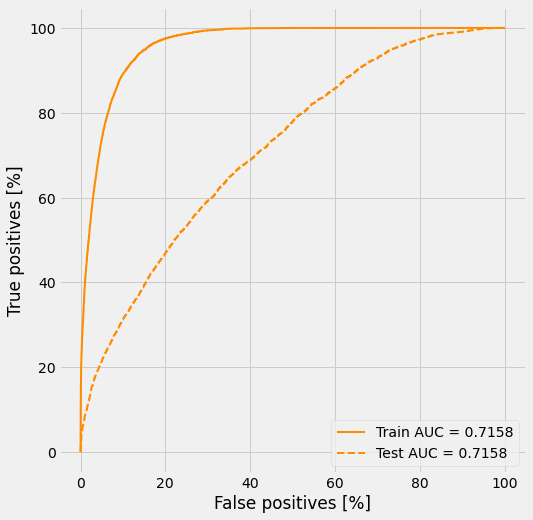

In [67]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    
    roc_auc = auc(fpr, tpr)
    #plt.figure(figsize=[8, 6])
    plt.plot(100*fp, 100*tp, label=name+'AUC = %0.4f' % roc_auc, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5, 80])
    #plt.ylim([60, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


train_predictions = model.predict(X_train, batch_size=2048)
test_predictions = model.predict(X_test, batch_size=2048)


#print('AUC = %0.4f' % roc_auc)
plt.figure(figsize=[8, 8])
plot_roc("Train ", train_labels, train_predictions, color='darkorange')
plot_roc("Test ", test_labels, test_predictions, color='darkorange', linestyle='--')
plt.legend(loc='lower right')

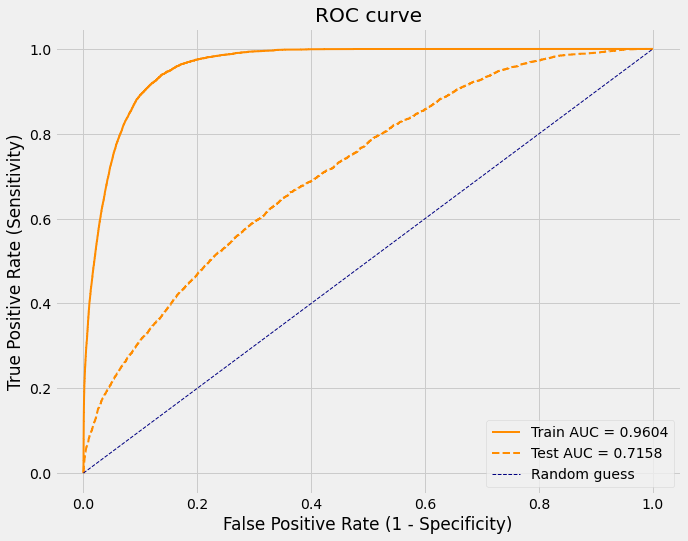

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

train_predictions = model.predict(X_train, batch_size=2048)
#test_predictions = model.predict(X_test, batch_size=2048)

fpr_train, tpr_train, _ = roc_curve(train_labels, train_predictions)

fpr, tpr, _ = roc_curve(test_labels, y_pred)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr, tpr)
plt.figure(figsize=[10, 8])
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train AUC = %0.4f' % roc_auc_train)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Test AUC = %0.4f' % roc_auc_test, linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

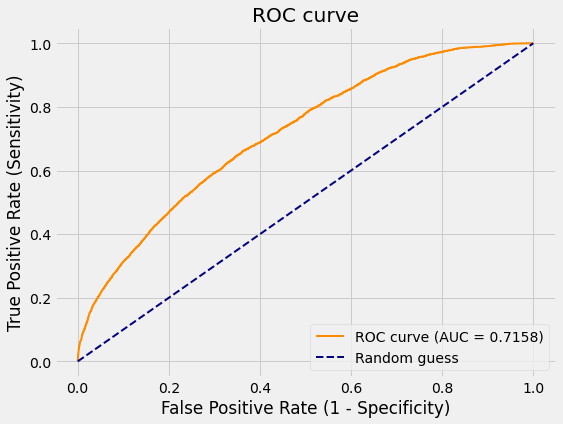

In [60]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(test_labels, y_pred)

roc_auc = auc(fpr, tpr)
plt.figure(figsize=[8, 6])
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(test_labels, y_pred)

roc_auc = auc(fpr, tpr)
plt.figure(figsize=[8, 6])
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(test_labels.drop(np.where(np.isnan(y_pred))[0]), # remove any NAs in prediction
                        np.delete(y_pred, np.where(np.isnan(y_pred))[0]))

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
print('auc: ', auc(fpr, tpr))

In [ ]:
# Evaluate by the performance of (simulated) inpsection

def inspection_performance(predicted_fraud, test_fraud):
    
    # Set default values before a loop
    
    Inspect_Rate = []
    Precision=[]
    Recall=[]
    
    # Create a loop for making confusion matrix at each inspection rate

    for i in range(1,100,1):
        
        # Find the ith value in ascending order.
        threshold = np.percentile(predicted_fraud, i)
        # Precision = number of frauds / number of inspection
        precision = np.mean(test_fraud[predicted_fraud > threshold])
        # Recall = number of inspected frauds / number of frauds
        recall = sum(test_fraud[predicted_fraud > threshold])/sum(test_fraud)
        # Save values
        Inspect_Rate.append(100-i)
        Precision.append(precision)
        Recall.append(recall)
        
    
    compiled_conf_matrix = pd.DataFrame({
        
        'Inspect_Rate':Inspect_Rate,
        'Precision':Precision,
        'Recall':Recall
    })

    return compiled_conf_matrix

In [ ]:
basic_performance = inspection_performance(y_pred, test_labels)

In [ ]:
basic_performance.head(5)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.melt(basic_performance, 
               id_vars = ['Inspect_Rate'],
               value_vars = ['Recall','Precision'])

sns.relplot(x='Inspect_Rate',
            y='value',
            hue='variable',
            col='variable',
            kind='line',
            data=data)

In [ ]:
# install plotly --> https://plotly.com/python/getting-started/#installation
import plotly.express as px

# Interactive visualization
fig = px.line(data, x="Inspect_Rate", y="value", color='variable',facet_col="variable")
fig.show()